<a href="https://colab.research.google.com/github/CogitoNTNU/course-on-cnn-and-pytorch/blob/main/SOLUTIONS_introduction_to_pytorch_and_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Pytroch and CNN

In [ ]:
! pip install torch torchvision pandas numpy matplotlib pillow tqdm

## Agenda
1. Introduction to Deep Learning
2. Datasets and DataLoaders
3. CNNs
4. Training Loop
5. Specific CNN Architectures

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Datasets

In PyTorch, a dataset is represented by any class that inherits from the Dataset abstract class. The Dataset class just requires the class to implement the `__len__` and `__getitem__` method. The `__len__` dunder method is the function that is called when calling `len(variable)`, and the __getitem__ method is what is called when you index a variable like this: `variable[index]`, usually done with lists.

The dataset class should handle everything from inputting the path to the folder or specified file of the dataset, and changing the dataset to what the model expects and can interpret efficiently. Often, a input argument to the class constructor can be `transform` and `target_transform`, these are functions that input the current data and return a new representation of the data (transforming the data). The `transform` is for transforming the input data. The `target_transform` is for transforming the ground truth.

The below example will show how to create a dataset class using pytorch with images from the internet. Usually when you create a dataset class you should have the dataset downloaded on your computer, and your just have to load the file paths. To avoid having everyone to download it, we will use some online files.

In [ ]:
# Example dataset using images from the internet
from torch.utils.data import Dataset
import requests
import json
from PIL import Image

class CatBreedDataset(Dataset):
    def __init__(self, image_paths_json_url: str, transform=None, target_transform=None):
        # This is a json array of the urls to the images, saved as a python list
        # Here we are using the requests library to fetch from urls,
        # this would usually not be used typically as the dataset would be
        # stored locally on your machine.
        self.image_paths = requests.get(image_paths_json_url).json()
        self.transform = transform
        self.target_transform = target_transform
        # Create an array of all the labels, is nice to have for later
        self.labels = list(set([path.split("/")[-2] for path in self.image_paths]))
        print("labels", self.labels)


    def __len__(self):
        # The length of the dataset is equal to the number of images in the list
        return len(self.image_paths)


    def __getitem__(self, index):
        # Retrieving the image
        image_url = self.image_paths[index]
        print("image_url", image_url)
        # Fetching the image
        image_raw = requests.get(image_url, stream=True).raw
        # Loading the image with the Pillow library
        image = Image.open(image_raw)
        image.convert("RGB")  # Just ensure it is in RGB format
        # The label of the cat is conventiently in the url
        label = image_url.split("/")[-2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label




In [ ]:
json_url = "https://storage.googleapis.com/catmatch/full_image_paths.json"
dataset = CatBreedDataset(json_url)

labels ['Abyssinian', 'Egyptian Mau', 'American Bobtail', 'American Shorthair', 'Birman', 'Russian Blue', 'Sphynx', 'British Shorthair', 'Persian', 'Maine Coon', 'Ragdoll', 'Bengal', 'Bombay', 'Siamese', 'Tuxedo']


image_url https://storage.googleapis.com/catmatch/.data/Abyssinian/Abyssinian-13743713_251.jpg
Label:  Abyssinian
Image shape (199, 300, 3)


(-0.5, 299.5, 198.5, -0.5)

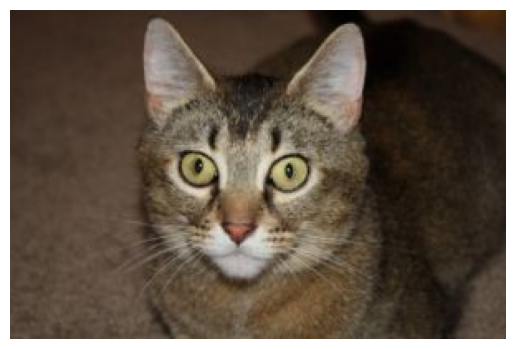

In [ ]:
image, label = dataset[0]
print("Label: ", label)
print("Image shape", np.array(image).shape)
plt.imshow(image)
plt.axis("off")

## Transforms

In the code implementation above there is the `transform` and `target_transform` optional paramters to the constructor that was mentioned earlier. Now we will apply this. Let's say we want to resize the images to a constant size and we want to normalize the colors. Here, we can also use `target_transform` to make a one-hot encoding of the labels.  

Here we can use torchvision's transforms module.

labels ['Abyssinian', 'Egyptian Mau', 'American Bobtail', 'American Shorthair', 'Birman', 'Russian Blue', 'Sphynx', 'British Shorthair', 'Persian', 'Maine Coon', 'Ragdoll', 'Bengal', 'Bombay', 'Siamese', 'Tuxedo']
image_url https://storage.googleapis.com/catmatch/.data/Abyssinian/Abyssinian-13743713_251.jpg
Transformed label 0


(-0.5, 243.5, 243.5, -0.5)

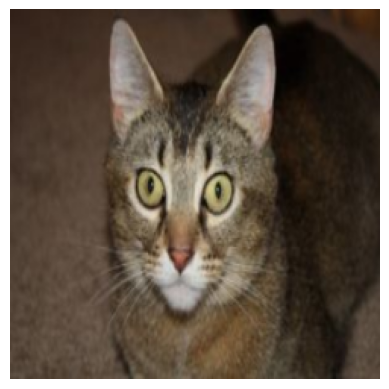

In [ ]:
from torchvision import transforms
import torch.nn.functional as F


image_transforms = transforms.Compose([
    transforms.Resize((244, 244)),
    # transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    transforms.ColorJitter(),
    transforms.ToTensor(),
])



transformed_dataset = CatBreedDataset(json_url, transform=image_transforms)
transformed_dataset.target_transform = lambda label: transformed_dataset.labels.index(label)
image, label = transformed_dataset[0]
print("Transformed label", label)
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")

## Tasks

1. Below you are given a list of dictionaries in the `data` variable. Each dicitonary in the list has a key `"url"` and `"breed"` which contains the urls to the image and the breed of that cat (the label) respectively. Create a dataset class using this data that inherits from the `Dataset` class in pytorch, and implements the `__len__` and `__getitem__` methods. The `__len__` method should return the length of the dataset, and the `__getitem__` method should return the image as a PIL image and the corresponding label as a tuple.

2. Pass transform and target_transform to the dataset class. The image should be resized to 244 * 244, have a Gaussian blur applied, and be converted to a PyTorch Tensor in the end. The label should be converted to a number, representing the position of the label in a "labels" attribute on the SampleBreeds instance. (Tip: Look at the documentation for torchvision.transforms)

3. Create a DataLoader for your instance of your dataset. The DataLoader instance should have a batch size of 2 and be shuffled. (Tip: Look at the documentation for pytorch's DataLoader class). Loop through the dataloader and print the images and labels in each batch.


image_url https://storage.googleapis.com/catmatch/.data/Bombay/Bombay_161.jpg
Label:  0
Image shape (3, 244, 244)


(-0.5, 243.5, 243.5, -0.5)

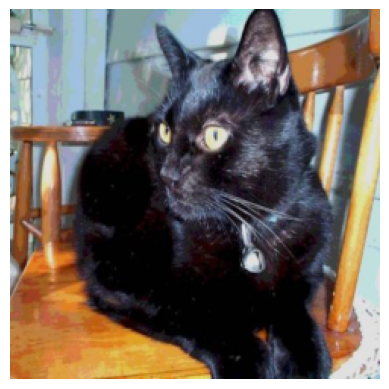

In [ ]:
data = [{"url": "https://storage.googleapis.com/catmatch/.data/Bombay/Bombay_161.jpg", "breed": "Bombay"}, {"url": "https://storage.googleapis.com/catmatch/.data/Sphynx/Sphynx_172.jpg", "breed": "Sphynx"}, {"url": "https://storage.googleapis.com/catmatch/.data/Bengal/Bengal-22233717_8242.jpg", "breed": "Bengal"}, {"url": "https://storage.googleapis.com/catmatch/.data/British Shorthair/British_Shorthair_266.jpg", "breed": "British Shorthair"}, {"url": "https://storage.googleapis.com/catmatch/.data/Bombay/Bombay-20316061_7998.jpg", "breed": "Bombay"}, {"url": "https://storage.googleapis.com/catmatch/.data/British Shorthair/British_Shorthair_134.jpg", "breed": "British Shorthair"}, {"url": "https://storage.googleapis.com/catmatch/.data/British Shorthair/British_Shorthair_176.jpg", "breed": "British Shorthair"}, {"url": "https://storage.googleapis.com/catmatch/.data/Maine Coon/Maine_Coon-43510901_5974.jpg", "breed": "Maine Coon"}, {"url": "https://storage.googleapis.com/catmatch/.data/Egyptian Mau/Egyptian_Mau-33523925_490.jpg", "breed": "Egyptian Mau"}, {"url": "https://storage.googleapis.com/catmatch/.data/Siamese/Siamese_56.jpg", "breed": "Siamese"}]

class SampleBreeds(Dataset):

    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.labels = [item["breed"] for item in self.data]
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        image_url = item["url"]
        print("image_url", image_url)
        # Fetching the image
        image_raw = requests.get(image_url, stream=True).raw
        # Loading the image with the Pillow library
        image = Image.open(image_raw)
        image.convert("RGB")  # Just ensure it is in RGB format
        # The label of the cat is conventiently in the url
        label = item["breed"]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Setup
cat_transforms = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.GaussianBlur(5),
    transforms.ToTensor()
])
cat_dataset = SampleBreeds(data, transform=cat_transforms)
cat_dataset.target_transform = lambda label: cat_dataset.labels.index(label)

# Testing
image, label = cat_dataset[0]
print("Label: ", label)
print("Image shape", np.array(image).shape)
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")


image_url https://storage.googleapis.com/catmatch/.data/British Shorthair/British_Shorthair_134.jpg
image_url https://storage.googleapis.com/catmatch/.data/Bombay/Bombay_161.jpg
batch 0


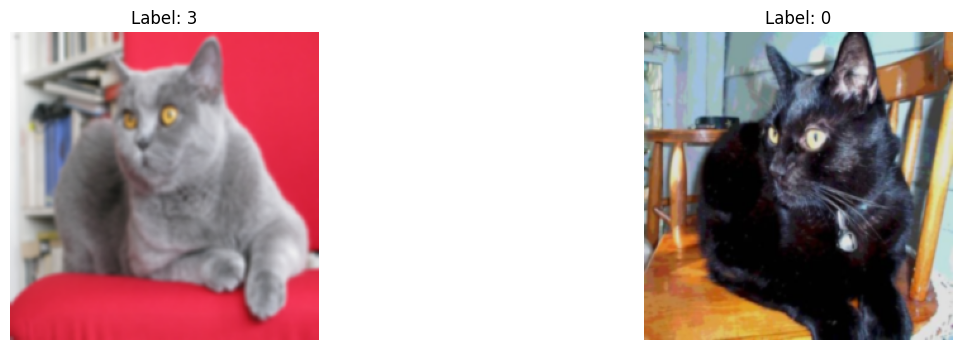

image_url https://storage.googleapis.com/catmatch/.data/Bombay/Bombay-20316061_7998.jpg
image_url https://storage.googleapis.com/catmatch/.data/Siamese/Siamese_56.jpg
batch 1


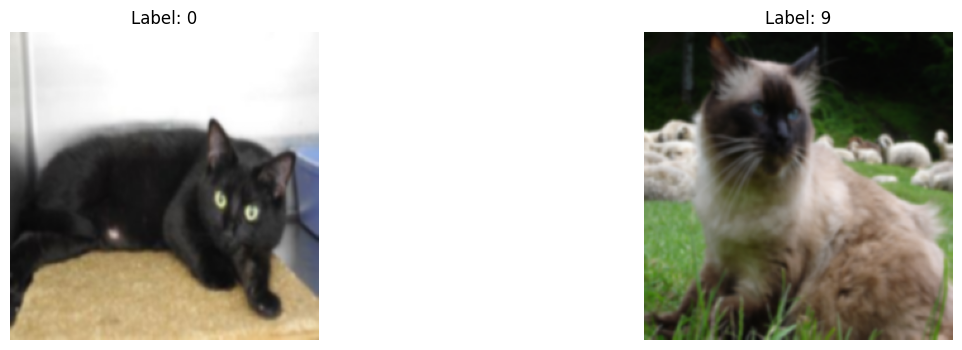

image_url https://storage.googleapis.com/catmatch/.data/Sphynx/Sphynx_172.jpg
image_url https://storage.googleapis.com/catmatch/.data/Bengal/Bengal-22233717_8242.jpg
batch 2


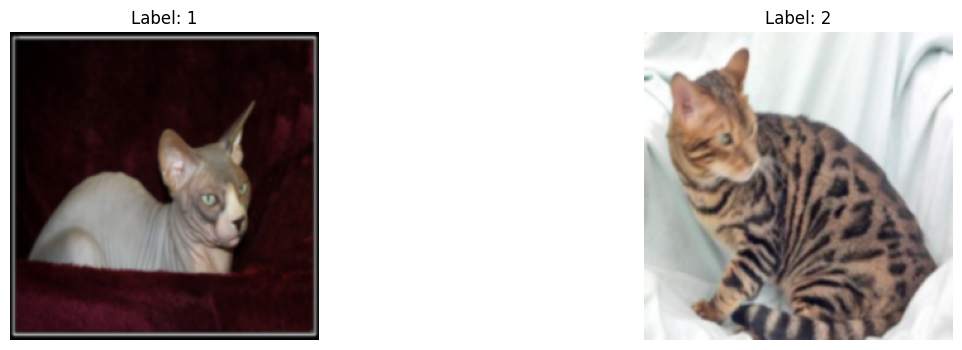

image_url https://storage.googleapis.com/catmatch/.data/British Shorthair/British_Shorthair_176.jpg
image_url https://storage.googleapis.com/catmatch/.data/Maine Coon/Maine_Coon-43510901_5974.jpg
batch 3


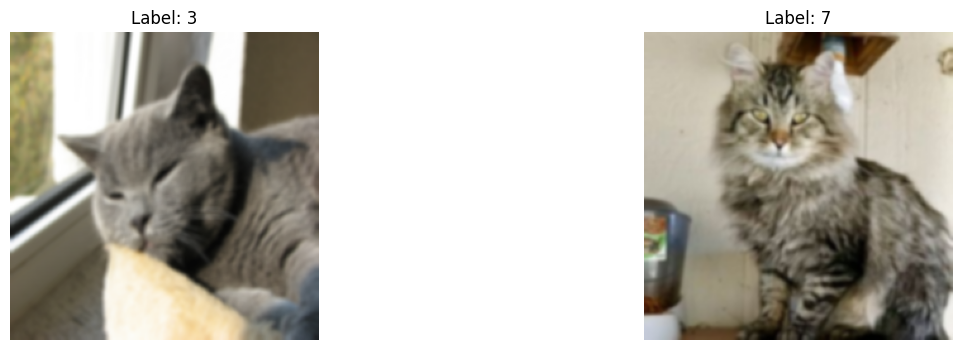

image_url https://storage.googleapis.com/catmatch/.data/British Shorthair/British_Shorthair_266.jpg
image_url https://storage.googleapis.com/catmatch/.data/Egyptian Mau/Egyptian_Mau-33523925_490.jpg
batch 4


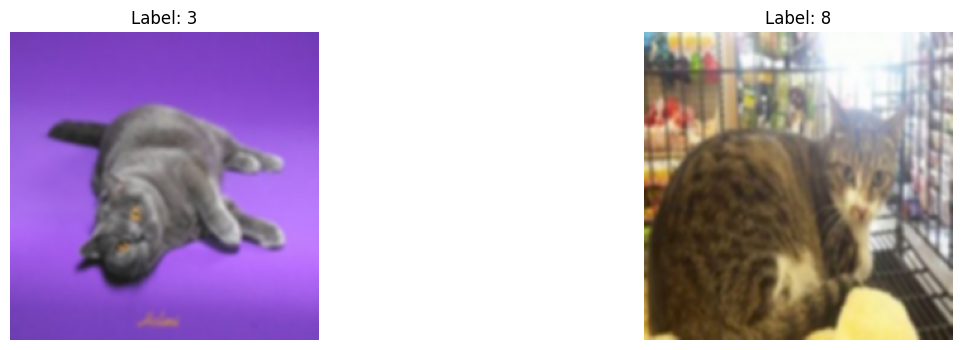

In [ ]:
from torch.utils.data import DataLoader
cat_dataloader = DataLoader(cat_dataset, batch_size=2, shuffle=True)

for index, (images, labels) in enumerate(cat_dataloader):
    print("batch", index)
    images = images.numpy()  # Convert tensors to numpy arrays for visualization
    fig, axs = plt.subplots(1, len(images), figsize=(15, 4))
    for i, ax in enumerate(axs):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()







# CNNs



## Task: Implement Convolution


1. Implement the function below that implements convolution over an image given a kernel. The function should slide the kernel over the image, compute the element-wise multiplication between the kernel and the portion of the image it covers, and sum up the results to form an output matrix. (Tip: Its just a bunch of for loops)

2. What does this the result indicate? What can convolution detect?

In [ ]:
# Credit: Jarl Sondre Sæther

image = np.array([
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)

k = np.array([
  [1, 0, -1],
  [2, 0, -2],
  [1, 0, -1]]
)

def convolve(arr, kernel):
    """Function for convolving a kernel over an array

    Note:
      - Expects input kernel to be smaller than arr in all dimensions

    """
    print(arr.shape, len(arr), kernel.shape)
    res = []
    for i in range(0, arr.shape[0] - kernel.shape[0] + 1):
        row = []
        for j in range(0, arr.shape[1] - kernel.shape[1] + 1):
            part = arr[i : i + kernel.shape[0], j : j + kernel.shape[1]]
            if part.shape != kernel.shape:
                break
            # print("part with shape ", part.shape, part)
            # sum up part * kernel
            sum = 0
            for k in range(0, kernel.shape[0]):
                for l in range(0, kernel.shape[1]):
                    sum += part[k][l] * kernel[k][l]
            row.append(sum)
        res.append(row)
    return np.array(res)


result = convolve(image, k)

expected = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -1, -1, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, -3, -3, 0, 0, 0, 0, 0, 3, 3, 0],
    [0, -4, -4, 0, 0, 0, 0, 0, 4, 4, 0],
    [0, -4, -4, 0, 0, 0, 0, 0, 4, 4, 0],
    [0, -4, -4, 0, 0, 0, 0, 0, 4, 4, 0],
    [0, -4, -4, 0, 0, 0, 0, 0, 4, 4, 0],
    [0, -3, -3, 0, 0, 0, 0, 0, 3, 3, 0],
    [0, -1, -1, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)

is_correct = np.array_equal(expected, result)
if is_correct:
    print("You are correct!")
else:
    print("That is wrong, try again")


(12, 13) 12 (3, 3)
You are correct!


## Answers
2. The result indicates that convolution/cross-correlation is able to detect edges in the image and changes in color. This can help identify edges, and thus objects in an image.

## Task: Implement Max Pool

1. Implement the function max_pool which takes in a n\*n matrix, the kernel_size, k and the stride, s, and produces a matrix that is has height and width (n-k)/s+1, where at each iteration over the kernel through the matrix, the maximum value of that part of the matrix is chosen.

2. What is the point with max pooling?

In [ ]:
array = np.array([
    [2, 2, 7, 3],
    [9, 4, 6, 1],
    [8, 5, 2, 4],
    [3, 1, 2, 6]
])

def max_pool(array, kernel_size=2, stride=2):
    # Calculate output dimensions
    out_height = (array.shape[0] - kernel_size) // stride + 1
    out_width = (array.shape[1] - kernel_size) // stride + 1

    # Initialize the output matrix
    pooled_matrix = np.zeros((out_height, out_width))

    # Apply max pooling
    for i in range(out_height):
        for j in range(out_width):
            row_start = i * stride
            row_end = i * stride + kernel_size
            col_start = j * stride
            col_end = j * stride + kernel_size
            window = array[row_start:row_end, col_start:col_end]
            pooled_matrix[i, j] = np.max(window)

    return pooled_matrix



result = max_pool(array)
expected = [
    [9, 7],
    [8, 6]
]


is_correct = np.array_equal(expected, result)
if is_correct:
    print("Correct!")
else:
    print("Wrong! Try again")




Correct!


## Answers
2. Max pooling is also to reduce the dimensionality of the tensor. It goes through with a window, and chooses the maximum value. Thus for each window that window is represented with the maximum value. This loses some information, but makes the feature map more dense making it easier to process. It also emphasizes the most present feature, and suppresses noise, which leads to more efficient learning.


## Implementing a CNN in PyTorch

In this section we will implement a simple CNN model in PyTorch.

In [ ]:
import torch.nn as nn

import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, in_channels, input_size):
        super(SimpleCNN, self).__init__()
        self.cnn = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            # Layer 2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 3 - NEW
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # Calculate the size of the output from the last convolutional layer
        # Here we assume that the input size is square (width = height)
        conv_output_size = input_size // 4  # After two MaxPool2d layer with kernel_size=2, stride=2
        # NEW - 4 instead of 2
        # Calculate the total number of features for the fully connected layer
        self.num_features = 32 * conv_output_size * conv_output_size

        self.classifier = nn.Linear(in_features=self.num_features, out_features=num_classes)

    def forward(self, x):
        feature_map = self.cnn(x)
        # Flatten the output for the fully connected layer
        out = feature_map.view(feature_map.size(0), -1)
        class_scores = self.classifier(out)
        return class_scores



In [ ]:
torch.cuda.is_available()

True

In [ ]:
def validate(model, val_dataloader, loss_criterion, device="cuda"):
    print("Validation")
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for index, batch in pbar:
            x, labels = batch
            x, labels = x.to(device), labels.to(device)
            pred = model(x)
            loss = loss_criterion(pred, labels)
            total_loss += loss.detach().cpu()
            accuracy = torch.sum(torch.eq(torch.argmax(pred, dim=1), labels)) / x.shape[0]
            total_accuracy += accuracy
            pbar.set_postfix_str(
                f"average loss {total_loss/(index+1):.3f}, average acc {total_accuracy/(index+1):.3f}"
            )
    return total_loss/len(val_dataloader)



def train(model, train_dataloader, val_dataloader, loss_criterion, optimizer, epochs, device="cuda"):
    for epoch in range(epochs):
        print("--- Epoch", epoch + 1, " ---")
        pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        total_loss = 0
        total_accuracy = 0
        best_loss = 100000000
        for index, batch in pbar:
            x, labels = batch
            x, labels = x.to(device), labels.to(device)
            pred = model(x)
            loss = loss_criterion(pred, labels)  # Calculate loss
            loss.backward()  # Do backpropagation
            optimizer.step()  # Optimize weights using the optimizer
            optimizer.zero_grad()
            total_loss += loss.detach().cpu()
            accuracy = torch.sum(torch.eq(torch.argmax(pred, dim=1), labels)) / x.shape[0]
            total_accuracy += accuracy
            pbar.set_postfix_str(
                f"average loss {total_loss/(index+1):.3f}, average accuracy {total_accuracy/(index+1):.3f}"
            )
        val_loss = validate(model, val_dataloader, loss_criterion, device)
        if val_loss <= best_loss:
            best_loss = val_loss
            # Save model
        print("\n")






100%|██████████| 9912422/9912422 [00:00<00:00, 57322089.13it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27493348.58it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41335051.05it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18212742.61it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

dataset length 60000
label 5


(-0.5, 27.5, 27.5, -0.5)

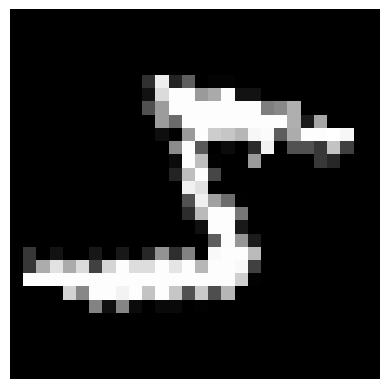

In [ ]:
from torchvision.datasets import MNIST

# Using the MNIST Dataset
# HERE IS NEW
used_transforms = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.ToTensor()
])
mnist_dataset = MNIST("data", download=True, transform=used_transforms)

image, label = mnist_dataset[0]
print("dataset length", len(mnist_dataset))
print("label", label)

# Need to convert from a [1, 28, 28] tensor to a [28, 28] tensor to show in grayscale
img_presentable = image.squeeze()
plt.imshow(img_presentable, cmap="gray")
plt.axis("off")


In [ ]:
from torch.utils.data import random_split, DataLoader
from torch.optim import SGD
# Training setup

LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 16
DEVICE = "cuda"

data_train, data_val = random_split(mnist_dataset, [0.8, 0.2])
train_dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False)

input_size = mnist_dataset[0][0].shape[1]  # 28
input_channels = mnist_dataset[0][0].shape[0]
print("input_size, channels", input_size, input_channels)
model = SimpleCNN(num_classes=len(mnist_dataset.classes), in_channels=input_channels, input_size=input_size).to(DEVICE)

loss_criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = SGD(model.parameters(), LEARNING_RATE)
train(model, train_dataloader, val_dataloader, loss_criterion, optimizer, epochs=EPOCHS, device=DEVICE)

input_size, channels 28 1
--- Epoch 1  ---


100%|██████████| 3000/3000 [00:33<00:00, 89.46it/s, average loss 1.097, average accuracy 0.653] 


Validation


100%|██████████| 750/750 [00:05<00:00, 142.28it/s, average loss 0.605, average acc 0.815]




--- Epoch 2  ---


100%|██████████| 3000/3000 [00:26<00:00, 114.22it/s, average loss 0.468, average accuracy 0.859]


Validation


100%|██████████| 750/750 [00:05<00:00, 133.98it/s, average loss 0.401, average acc 0.880]




--- Epoch 3  ---


100%|██████████| 3000/3000 [00:26<00:00, 114.06it/s, average loss 0.354, average accuracy 0.893]


Validation


100%|██████████| 750/750 [00:07<00:00, 106.00it/s, average loss 0.337, average acc 0.897]




--- Epoch 4  ---


100%|██████████| 3000/3000 [00:26<00:00, 111.28it/s, average loss 0.306, average accuracy 0.908]


Validation


100%|██████████| 750/750 [00:05<00:00, 141.18it/s, average loss 0.300, average acc 0.909]




--- Epoch 5  ---


100%|██████████| 3000/3000 [00:27<00:00, 110.37it/s, average loss 0.276, average accuracy 0.917]


Validation


100%|██████████| 750/750 [00:05<00:00, 133.89it/s, average loss 0.271, average acc 0.920]




--- Epoch 6  ---


100%|██████████| 3000/3000 [00:26<00:00, 114.16it/s, average loss 0.254, average accuracy 0.923]


Validation


100%|██████████| 750/750 [00:05<00:00, 133.81it/s, average loss 0.252, average acc 0.923]




--- Epoch 7  ---


100%|██████████| 3000/3000 [00:26<00:00, 113.70it/s, average loss 0.240, average accuracy 0.928]


Validation


100%|██████████| 750/750 [00:05<00:00, 140.25it/s, average loss 0.239, average acc 0.926]




--- Epoch 8  ---


100%|██████████| 3000/3000 [00:26<00:00, 112.65it/s, average loss 0.223, average accuracy 0.934]


Validation


100%|██████████| 750/750 [00:05<00:00, 127.98it/s, average loss 0.225, average acc 0.931]




--- Epoch 9  ---


100%|██████████| 3000/3000 [00:26<00:00, 113.61it/s, average loss 0.210, average accuracy 0.936]


Validation


100%|██████████| 750/750 [00:05<00:00, 142.43it/s, average loss 0.229, average acc 0.931]




--- Epoch 10  ---


100%|██████████| 3000/3000 [00:27<00:00, 110.19it/s, average loss 0.194, average accuracy 0.940]


Validation


100%|██████████| 750/750 [00:05<00:00, 139.31it/s, average loss 0.218, average acc 0.932]

## Tasks CNN Implementation
1. Modify the SimpleCNN network and add an additional convolutional layer to the network. Retrain the network. Does the accuracy improve? Why?

2. Add transforms to the training loop (ex. random rotation). How does this impact performance?

3. Usually, it is normal to have a "test" dataset as well. Thus 80% is used for trianing and 20% for testing. Change the split to include a testset. Create a dataloader for the testset. Create a function "test", which uses the model on torch.no_grad() mode to test the model's performance on the test dataset after each epoch in the training loop. Why is it necessary to use a separate dataset for training? Is there still a problem with this approach?

## Answers

1. The accuracy improves because the deeper network is able to understand deeper features. It also has a more parameters.
2. Transforms will likely not improve the performance much here. The reason is that the data is too simple. Transforms will, however, impact performance a lot with bigger and color images, because it will make the model understand better feautres given noise and changes in the image. It essentially increases the dataset size.
3. A test dataset is essential because it ensures that the model learns something new. It shows new images to the model and evaluates them on those instead of evaluating it on images the model has already seen. Thus, the performance on the test dataset is the real performance. However, when evaluating the model performance after each epoch, you are sort of "training" on the test set. Thus you often introduce a validation dataset which is used after each epoch, and the test dataset is only used after the whole training loop and all epochs are finished.  

# Specific CNN architectures example

In [ ]:
# VGG16, from: https://blog.paperspace.com/vgg-from-scratch-pytorch/
# This is just inspiration
# I suggest not using this for the competition as it likely will
# take too much time to train and will need modifications to the dataset

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Competition: CIFAR10

Simple goal: Create a custom CNN with as high accuracy as possible.
Rules:
1. You cannot use pretrained or prebuilt networks, like ResNet50 from torchvision
2. Use the last 20% of the dataset for testing. This data cannot be trained on. (See `cifar_test` and `cifar_trainable`)
3. You can only train on the trainable CIFAR10 data, and no other data.
4. You can create as big network as you choose using anything from torch.nn, as long as you build it yourself.
5. You have to complete the challenge within the time limit.

100%|██████████| 170498071/170498071 [00:03<00:00, 49038610.61it/s]


Extracting datacifar/cifar-10-python.tar.gz to datacifar
Files already downloaded and verified
dataset length 50000
label 6 Frog


(-0.5, 31.5, 31.5, -0.5)

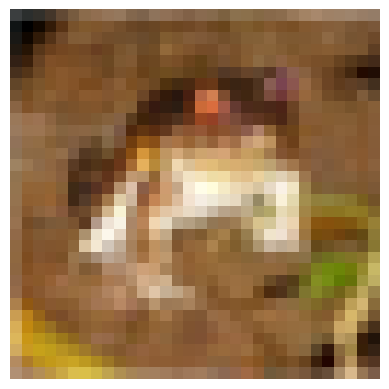

In [ ]:


from torch.utils.data import random_split, DataLoader, Subset
from torch.optim import SGD
# Training setup
from torchvision.datasets import CIFAR10

# NEW
cifar_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Apply the transforms to the CIFAR dataset
# Here the transforms are applied to both the train and test set
# As you do not want to apply the transforms to the test set, we are creating
# separate instances of the data class for each
cifar_dataset = CIFAR10("datacifar", download=True, transform=transforms.ToTensor())
cifar_dataset_transforms = CIFAR10("datacifar", download=True, transform=cifar_transforms)
cifar10_classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

cutoff = int(0.8*len(cifar_dataset))
cifar_test = Subset(cifar_dataset, range(cutoff, len(cifar_dataset)))
cifar_trainable = Subset(cifar_dataset_transforms, range(cutoff))

image, label = cifar_dataset[0]
print("dataset length", len(cifar_dataset))
print("label", label, cifar10_classes[int(label)])

img_presentable = image.permute(1, 2, 0)
plt.imshow(img_presentable)
plt.axis("off")


In [ ]:
import torch.nn as nn

class RevolutionCNN(nn.Module):
    def __init__(self, num_classes, in_channels, input_size):
        super(RevolutionCNN, self).__init__()
        self.cnn = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            # Layer 2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 3 - NEW
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            # Layer 4 - NEW
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 5 - NEW
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

        )


        # Calculate the size of the output from the last convolutional layer
        # Here we assume that the input size is square (width = height)
        number_of_max_pool = 2
        conv_output_size = input_size // (2 ** number_of_max_pool)
        self.num_features = 32 * conv_output_size * conv_output_size  # After two MaxPool2d layer with kernel_size=2, stride=2
        # NEW - 4 instead of 2
        # Calculate the total number of features for the fully connected layer
        self.num_features = 32 * conv_output_size * conv_output_size

        self.classifier = nn.Linear(in_features=self.num_features, out_features=num_classes)

    def forward(self, x):
        feature_map = self.cnn(x)
        # Flatten the output for the fully connected layer
        out = feature_map.view(feature_map.size(0), -1)
        class_scores = self.classifier(out)
        return class_scores



LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 32
DEVICE = "cuda"
train_dataloader = DataLoader(cifar_trainable, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(cifar_test, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(cifar_test, batch_size=BATCH_SIZE, shuffle=False)

input_size = cifar_dataset[0][0].shape[1]  # 32
input_channels = cifar_dataset[0][0].shape[0]
print("input_size, channels", input_size, input_channels)
model = RevolutionCNN(num_classes=len(cifar_dataset.classes), in_channels=input_channels, input_size=input_size).to(DEVICE)

loss_criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = SGD(model.parameters(), LEARNING_RATE)
train(model, train_dataloader, val_dataloader, loss_criterion, optimizer, epochs=EPOCHS, device=DEVICE)
validate(model, test_dataloader, loss_criterion, device=DEVICE)

input_size, channels 32 3
--- Epoch 1  ---


100%|██████████| 1250/1250 [00:19<00:00, 64.08it/s, average loss 1.655, average accuracy 0.405]


Validation


100%|██████████| 313/313 [00:03<00:00, 93.70it/s, average loss 1.406, average acc 0.492] 




--- Epoch 2  ---


100%|██████████| 1250/1250 [00:24<00:00, 52.07it/s, average loss 1.323, average accuracy 0.525]


Validation


100%|██████████| 313/313 [00:02<00:00, 108.22it/s, average loss 1.248, average acc 0.562]




--- Epoch 3  ---


100%|██████████| 1250/1250 [00:19<00:00, 64.97it/s, average loss 1.189, average accuracy 0.578]


Validation


100%|██████████| 313/313 [00:03<00:00, 95.59it/s, average loss 1.146, average acc 0.596] 




--- Epoch 4  ---


100%|██████████| 1250/1250 [00:19<00:00, 64.45it/s, average loss 1.102, average accuracy 0.613]


Validation


100%|██████████| 313/313 [00:03<00:00, 103.52it/s, average loss 1.081, average acc 0.618]




--- Epoch 5  ---


100%|██████████| 1250/1250 [00:20<00:00, 62.26it/s, average loss 1.034, average accuracy 0.639]


Validation


100%|██████████| 313/313 [00:02<00:00, 109.39it/s, average loss 1.019, average acc 0.640]




--- Epoch 6  ---


100%|██████████| 1250/1250 [00:19<00:00, 63.54it/s, average loss 0.983, average accuracy 0.656]


Validation


100%|██████████| 313/313 [00:02<00:00, 109.71it/s, average loss 0.967, average acc 0.660]




--- Epoch 7  ---


100%|██████████| 1250/1250 [00:19<00:00, 62.96it/s, average loss 0.938, average accuracy 0.671]


Validation


100%|██████████| 313/313 [00:02<00:00, 111.33it/s, average loss 0.934, average acc 0.672]




--- Epoch 8  ---


100%|██████████| 1250/1250 [00:19<00:00, 63.18it/s, average loss 0.902, average accuracy 0.684]


Validation


100%|██████████| 313/313 [00:02<00:00, 112.55it/s, average loss 0.923, average acc 0.678]




--- Epoch 9  ---


100%|██████████| 1250/1250 [00:21<00:00, 57.89it/s, average loss 0.871, average accuracy 0.695]


Validation


100%|██████████| 313/313 [00:02<00:00, 112.12it/s, average loss 0.881, average acc 0.692]




--- Epoch 10  ---


100%|██████████| 1250/1250 [00:19<00:00, 63.42it/s, average loss 0.848, average accuracy 0.703]


Validation


100%|██████████| 313/313 [00:02<00:00, 111.10it/s, average loss 0.879, average acc 0.690]




--- Epoch 11  ---


100%|██████████| 1250/1250 [00:19<00:00, 63.63it/s, average loss 0.823, average accuracy 0.715]


Validation


100%|██████████| 313/313 [00:02<00:00, 113.34it/s, average loss 0.845, average acc 0.706]




--- Epoch 12  ---


100%|██████████| 1250/1250 [00:19<00:00, 64.50it/s, average loss 0.804, average accuracy 0.719]


Validation


100%|██████████| 313/313 [00:03<00:00, 95.26it/s, average loss 0.835, average acc 0.707] 




--- Epoch 13  ---


100%|██████████| 1250/1250 [00:19<00:00, 65.09it/s, average loss 0.781, average accuracy 0.729]


Validation


100%|██████████| 313/313 [00:03<00:00, 96.44it/s, average loss 0.835, average acc 0.709]




--- Epoch 14  ---


100%|██████████| 1250/1250 [00:19<00:00, 64.62it/s, average loss 0.762, average accuracy 0.735]


Validation


100%|██████████| 313/313 [00:02<00:00, 111.19it/s, average loss 0.809, average acc 0.716]




--- Epoch 15  ---


100%|██████████| 1250/1250 [00:20<00:00, 62.41it/s, average loss 0.748, average accuracy 0.740]


Validation


100%|██████████| 313/313 [00:02<00:00, 112.49it/s, average loss 0.807, average acc 0.719]




--- Epoch 16  ---


100%|██████████| 1250/1250 [00:19<00:00, 62.93it/s, average loss 0.732, average accuracy 0.745]


Validation


100%|██████████| 313/313 [00:02<00:00, 111.54it/s, average loss 0.797, average acc 0.723]




--- Epoch 17  ---


100%|██████████| 1250/1250 [00:19<00:00, 62.96it/s, average loss 0.721, average accuracy 0.750]


Validation


100%|██████████| 313/313 [00:02<00:00, 110.59it/s, average loss 0.782, average acc 0.728]




--- Epoch 18  ---


100%|██████████| 1250/1250 [00:19<00:00, 63.63it/s, average loss 0.707, average accuracy 0.754]


Validation


100%|██████████| 313/313 [00:02<00:00, 108.57it/s, average loss 0.771, average acc 0.732]




--- Epoch 19  ---


100%|██████████| 1250/1250 [00:19<00:00, 62.77it/s, average loss 0.693, average accuracy 0.759]


Validation


100%|██████████| 313/313 [00:02<00:00, 106.95it/s, average loss 0.769, average acc 0.733]




--- Epoch 20  ---


100%|██████████| 1250/1250 [00:19<00:00, 64.44it/s, average loss 0.683, average accuracy 0.762]


Validation


100%|██████████| 313/313 [00:03<00:00, 93.68it/s, average loss 0.766, average acc 0.735] 




Validation


100%|██████████| 313/313 [00:02<00:00, 110.53it/s, average loss 0.766, average acc 0.735]


tensor(0.7661)